# Error Analysis

### Imports and Definitions

In [35]:
## import error analysis library
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import cooks_distance
import scipy.stats as stats
import pickle
import pandas as pd
import numpy as np
import sklearn.metrics as metrics 
import matplotlib.pyplot as plt

In [23]:
def regression_results(y_test, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mae=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
    r2=metrics.r2_score(y_test, y_pred)
    adj_r2 = 1 - ( 1-r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - training_data.shape[1] - 1 )


    print("The model performance for testing set")
    print("--------------------------------------")
    print('MAE is {}'.format(mae))
    print('MSE is {}'.format(mse))
    print('RMSE is {}'.format(mse**(1/2.0)))
    print('R2 score is {}'.format(r2))
    print('Adj R2 score is {}'.format(adj_r2))

### Setup

In [12]:
#Read in data
training_data = pd.read_csv('/home/ec2-user/capstone/broadband-capstone/data/current_data/train_3.csv')
test_data = pd.read_csv('/home/ec2-user/capstone/broadband-capstone/data/current_data/test_3.csv')

In [15]:
ind_vars  = ['Wired_Provider_Count',
             'median_age_overall',
             'Ookla Median Download Speed (Mbps)',
             'employment_rate',
             'pct_computing_device_with_broadband',
             'pct_only_cellular',
             'pct_computing_device',
             'pct_white',
             'pct_pop_disability',
             'pct_internet_broadband_satellite',
             'pct_internet',
             'pct_internet_broadband_any_type',
             'pct_pop_20_to_24']

target = ['poverty_rate']

X_train = training_data[ind_vars]
X_test = test_data[ind_vars]
y_train = training_data[target]
y_test = test_data[target]

In [18]:
## transfer to np array for error analysis
X_train_1 = np.squeeze(np.asarray(X_train))
y_train_1 = np.squeeze(np.asarray(y_train))
X_test_1 = np.squeeze(np.asarray(X_test))
y_test_1 = np.squeeze(np.asarray(y_test))

In [8]:
#Read in model
with open('/home/ec2-user/capstone/broadband-capstone/models/poverty_rate_random_forest_2.sav', 'rb') as f:
    rf2 = pickle.load(f)

In [19]:
#Feed in data to model
rf2.fit(X_train_1,y_train_1)
y_pred_1 = rf2.predict(X_test_1)

In [24]:
# model evaluation for testing set
regression_results(y_test_1, y_pred_1)

The model performance for testing set
--------------------------------------
MAE is 4.099793800994701
MSE is 31.396005084390396
RMSE is 5.603213817479251
R2 score is 0.737941922307207
Adj R2 score is 0.7340516699531588


## Residual plot

The residuals plot shows the difference between residuals on the vertical axis and the dependent variable on the horizontal axis, allowing you to detect regions within the target that may be susceptible to more or less error.

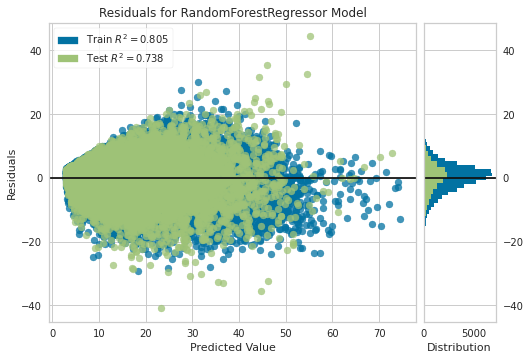

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [27]:
visualizer = ResidualsPlot(rf2)

visualizer.fit(X_train_1, y_train_1)  # Fit the training data to the visualizer
visualizer.score(X_test_1, y_test_1)  # Evaluate the model on the test data
visualizer.show()  

### Interpretations

In the case above, we see a slight leftward skew in the distribution of the residuals against the target in two dimensions. This effect is subtle though, and we can see from the histogram that our error is normally distributed around zero, which also generally indicates a well fitted model.

## Prediction Error Plot

A prediction error plot shows the actual targets from the dataset against the predicted values generated by our model. This allows us to see how much variance is in the model. Data scientists can diagnose regression models using this plot by comparing against the 45 degree line, where the prediction exactly matches the model.


Prediction Error Plot


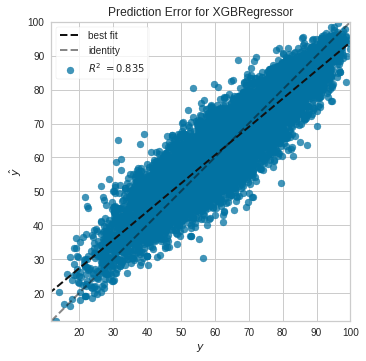

PredictionError(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3432bb8610>,
                estimator=XGBRegressor(alpha=10, colsample_bytree=0.3,
                                       learning_rate=0.05, max_depth=5,
                                       n_estimators=2500))


In [ ]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(rf2, X_train_1, y_train_1, X_test_1, y_test_1))


### Interpretations

We can see that most of the points are on a straight line. We can compare this plot against the 45-degree line, where the prediction exactly matches the model. In general, the predictions follow the actualS.

## Cook's distance

Cook’s Distance is a measure of how influential an instance is to the computation of a regression, e.g. if the instance is removed would the estimated coeficients of the underlying model be substantially changed? Because of this, Cook’s Distance is generally used to detect outliers in standard, OLS regression. In fact, a general rule of thumb is that D(i) > 4/n is a good threshold for determining highly influential points as outliers and this visualizer can report the percentage of data that is above that threshold.

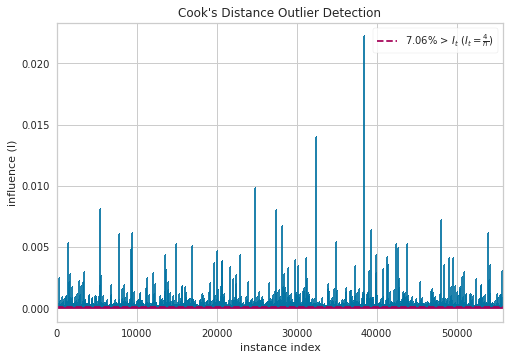

CooksDistance(ax=<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>)

In [28]:
cooks_distance(
    X_train_1, y_train_1,
    draw_threshold=True,
    linefmt="C0-", markerfmt=","
)

In particular, there are several (7.06%）of the observations with Cook’s distance values that are relatively higher than the others.

## Q-Q plot

To check the assumption of the normality of the data generating process, we can use Q-Q plot of the normalized residuals.

Text(0.5, 1.0, 'Normal Q-Q Plot')

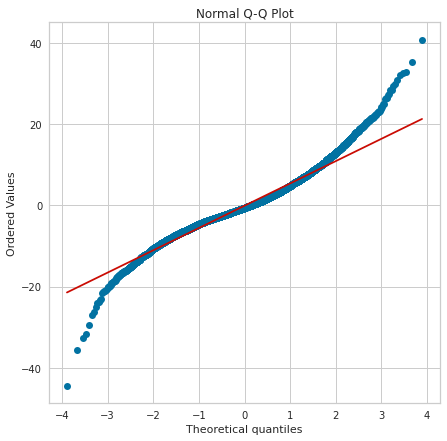

In [36]:
residuals = y_test["poverty_rate"] - y_pred_1.reshape(-1)
residuals

plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

## Interpretations

We can see that most residuals are fitted to the line, although there are outliers found at both ends. This suggests that the data overrepresents the central quantiles and underrepresents the lowest and highest quantiles.